In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Masking,LSTM, GRU, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.datasets import reuters
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import tensorflow_hub as hub

2024-05-01 18:47:12.157104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:47:12.157166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:47:12.158762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Import Data and Basic EDA**

In [2]:
data = pd.read_csv("/kaggle/input/disaster-tweets/tweets.csv", index_col = 'id' )
# shuffle the dataset 
data_shuffled = data.sample(frac=1, random_state=1)
data_shuffled.head(10)

,keyword,location,text,target
id,,,,
11132,windstorm,"Ridgway, PA",2 seconds. Why is she singing through her nose...,0
2116,catastrophe,NaN,"Water being trucked in , watching 7, 30 this i...",0
5593,fire,"Nashville, TN",i want some fire ass head.😭,0
4139,disaster,Sydney,Joined Premier &amp; Comm Baxter today to visi...,0
6133,hailstorm,"Chennai, India","UAE bracing up for heavy rain, hailstorm in UA...",1
3289,debris,NaN,"Unfortunately, both plans fail as the 3 are im...",0
8676,riot,NaN,if that thread is true and justin was a victim...,0
8136,panicking,Pearl Of The Orient,That's your positive side kicking in. But to d...,0
8213,police,NaN,"In 12 Northern States, the Hisbah (Islamic Pol...",0


In [3]:
data.shape

(11370, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11370 entries, 0 to 11369
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   11370 non-null  object
 1   location  7952 non-null   object
 2   text      11370 non-null  object
 3   target    11370 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 444.1+ KB


In [5]:
data.describe()

,target
count,11370.000000
mean,0.185928
std,0.389066
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# **Train Test Split**

In [6]:
# split the data into 90% training and 10% testing
X_train, X_test, y_train, y_test = train_test_split(data_shuffled["text"].to_numpy(),
                                                    data_shuffled["target"].to_numpy(),
                                                    test_size = 0.1,
                                                    random_state=1)
X_train.shape, y_train.shape

((10233,), (10233,))

In [7]:
X_train[0:5]

array(['The picture is from 2001, after fall of Taliban. They destroyed it by bombing during their regime in Afg b… https://t.co/hnnq4OGscG',
       'Presenting Asim Riaz Bravo :P "Hello 911 it\'s an emergency, there is a handsome guy in my house, oh! Wait a second cancel t…',
       '"Once the [scrapping] sale contract has been signed and the deal done, you have to ask how much else is expected of a dil…',
       'No Greta Gerwig for ‘Little Women,’ no Lulu Wang for ‘The Farewell,’ no Lorene Scafaria for ‘Hustlers,’ no Melina Matsou…',
       'It’s funny because I’ve lived in tundra szn and I’ve walked home from work in a snowstorm on a day… https://t.co/O1LHRHTY3w'],
      dtype=object)

In [8]:
text_vectorizer = TextVectorization(max_tokens=None, 
                                    #remove punctuation and make letters lowercase
                                    standardize="lower_and_strip_punctuation", 
                                    #whitespace delimiter
                                    split="whitespace", 
                                    #dont group anything, every token alone
                                    ngrams = None, 
                                    output_mode ="int",
                                    #length of each sentence == length of largest sentence
                                    output_sequence_length=None)

In [9]:
# number of words in the vocabulary 
max_vocab_length = 10000
# tweet average length
max_length = 15 

In [10]:
embedding = layers.Embedding(input_dim= max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

# **Import Transfer Learning Model**

In [11]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                               input_shape=[],
                               dtype = tf.string,
                               trainable=False)

Attaching model 'google/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2' to your Kaggle notebook...


In [12]:
# pip install tensorflow

In [13]:
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(loss="binary_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

Epoch 1/20


I0000 00:00:1714589251.711651     161 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 13s 14ms/step - loss: 0.4442 - accuracy: 0.8261 - val_loss: 0.3359 - val_accuracy: 0.8610
Epoch 2/20
320/320 [==============================] - 4s 11ms/step - loss: 0.3046 - accuracy: 0.8771 - val_loss: 0.2983 - val_accuracy: 0.8769
Epoch 3/20
320/320 [==============================] - 4s 12ms/step - loss: 0.2820 - accuracy: 0.8869 - val_loss: 0.2864 - val_accuracy: 0.8918
Epoch 4/20
320/320 [==============================] - 4s 12ms/step - loss: 0.2723 - accuracy: 0.8897 - val_loss: 0.2810 - val_accuracy: 0.8883
Epoch 5/20
320/320 [==============================] - 4s 11ms/step - loss: 0.2662 - accuracy: 0.8926 - val_loss: 0.2782 - val_accuracy: 0.8909
Epoch 6/20
320/320 [==============================] - 4s 11ms/step - loss: 0.2622 - accuracy: 0.8950 - val_loss: 0.2759 - val_accuracy: 0.8927
Epoch 7/20
320/320 [==============================] - 4s 11ms/step - loss: 0.2580 - accuracy: 0.8957 - val_loss: 0.2732 - val_accuracy: 0.8936
Epoch 8/2

<Axes: >

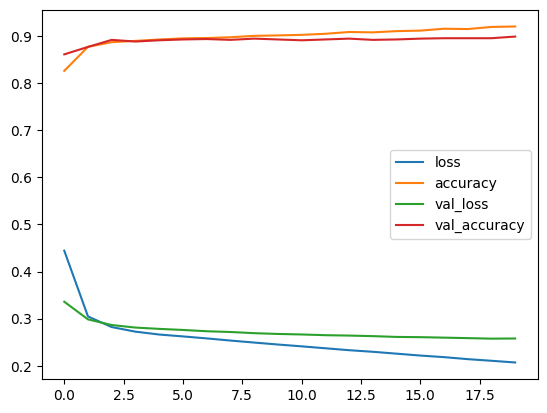

In [14]:
model_history = model.fit(x=X_train,
              y=y_train,
              epochs=20,
              validation_data=(X_test,y_test))
pd.DataFrame(model_history.history).plot()

In [15]:
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
    model_results = {"accuracy":model_accuracy,
                     "precision":model_precision,
                     "recall" :model_recall,
                     "f1":model_f1}
    return model_results

In [16]:
calculate_results(y_true=y_test,
                  y_pred=tf.squeeze(tf.round(model.predict(X_test))))

36/36 [==============================] - 1s 9ms/step


{'accuracy': 0.8988566402814424,
 'precision': 0.8956393794855374,
 'recall': 0.8988566402814424,
 'f1': 0.8967890051787295}